JUSTIFICAR PQ NOS CARGAMOS CO

poner en la memoria: pq nos quedamos con el trozo que nos quedamos, pq imputamos los nulos con la estrategia que lo hacemos
pq usamos un algoritmo de cada familia
ensembles heterogeneos para combinar lo mejor de cada familia

aunque los resultados sean malos analizarlos

guardar un intervalo del final para usar como intervalo de predicción

## Modelo con exógenas

In [56]:
!pip install --upgrade pandas pyarrow
!pip install skforecast

Defaulting to user installation because normal site-packages is not writeable


Defaulting to user installation because normal site-packages is not writeable


In [57]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from skforecast.recursive import ForecasterRecursive
from skforecast.model_selection import TimeSeriesFold, grid_search_forecaster, backtesting_forecaster

# Lee el archivo .gzip que contiene el parquet directamente
df = pd.read_parquet('bermejales.gzip')

# Muestra las primeras filas de la tabla para verificar
print(df.head())

              datetime         co      no2      o3  pm10     tmp      vv
0  2005-01-01 00:00:00  2269.0000  18.6667  2.5000   NaN  6.0000  0.3333
1  2005-01-01 01:00:00  2269.0000  18.6667  2.5000   NaN  6.0000  0.3333
2  2005-01-01 02:00:00  2024.6667  26.6667  7.5000   NaN  6.6667  1.0000
3  2005-01-01 03:00:00  2229.3333  19.6667  5.5000   NaN  6.1667  0.3333
4  2005-01-01 04:00:00  2096.1667  19.5000  4.6667   NaN  5.3333  0.8333


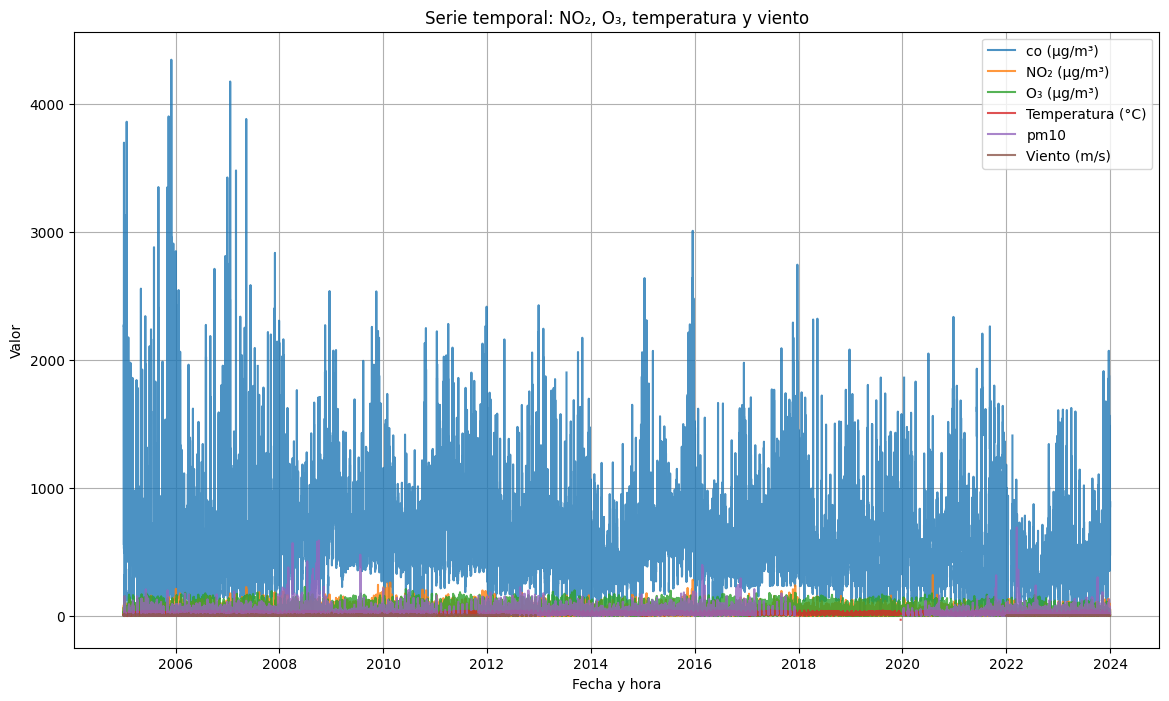

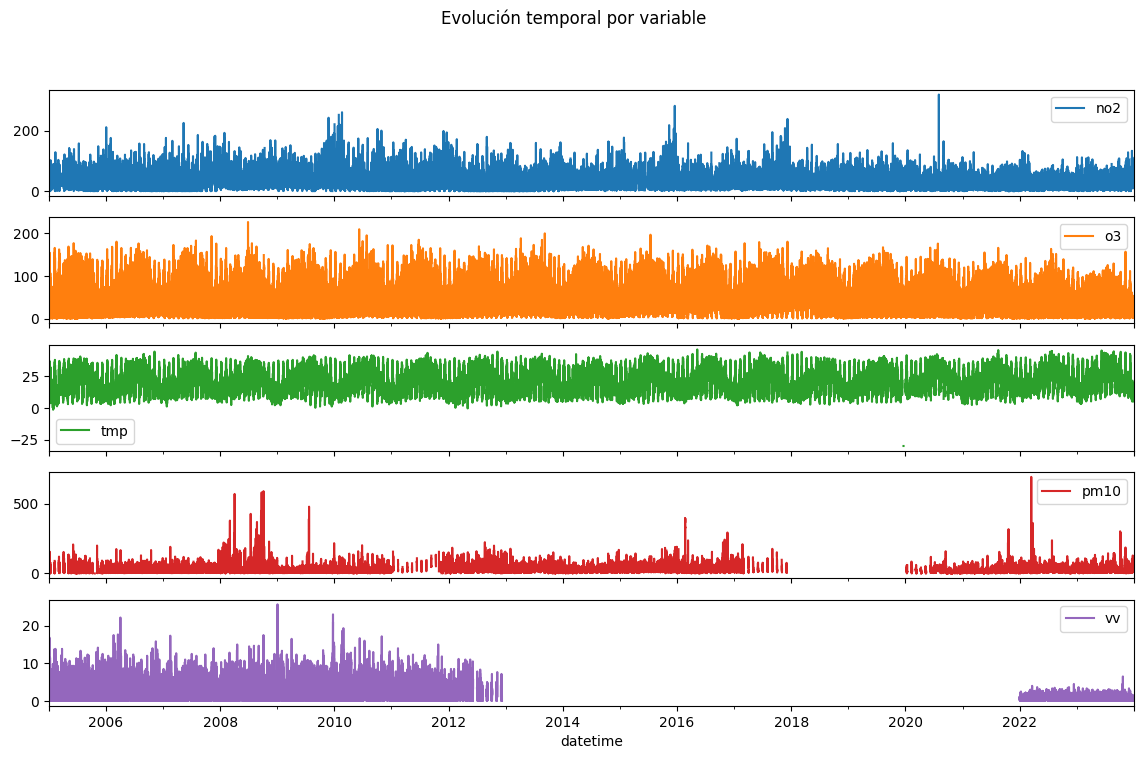

In [58]:
# --- 2. Convertir la columna datetime a tipo fecha ---
df['datetime'] = pd.to_datetime(df['datetime'])
df = df.sort_values('datetime')

# --- 3. Definir columna temporal como índice ---
df = df.set_index('datetime')

# --- 4. Visualización general ---
plt.figure(figsize=(14, 8))
plt.plot(df.index, df['co'], label='co (µg/m³)', alpha=0.8)
plt.plot(df.index, df['no2'], label='NO₂ (µg/m³)', alpha=0.8)
plt.plot(df.index, df['o3'], label='O₃ (µg/m³)', alpha=0.8)
plt.plot(df.index, df['tmp'], label='Temperatura (°C)', alpha=0.8)
plt.plot(df.index, df['pm10'], label='pm10', alpha=0.8)
plt.plot(df.index, df['vv'], label='Viento (m/s)', alpha=0.8)
plt.title('Serie temporal: NO₂, O₃, temperatura y viento')
plt.xlabel('Fecha y hora')
plt.ylabel('Valor')
plt.legend()
plt.grid(True)
plt.show()

# --- 5. Subgráficos por variable ---
variables = ['no2', 'o3', 'tmp','pm10', 'vv']
df[variables].plot(subplots=True, figsize=(14, 8), sharex=True, title='Evolución temporal por variable')
plt.show()

Mostrando datos desde 2023-10-08 hasta 2023-12-31


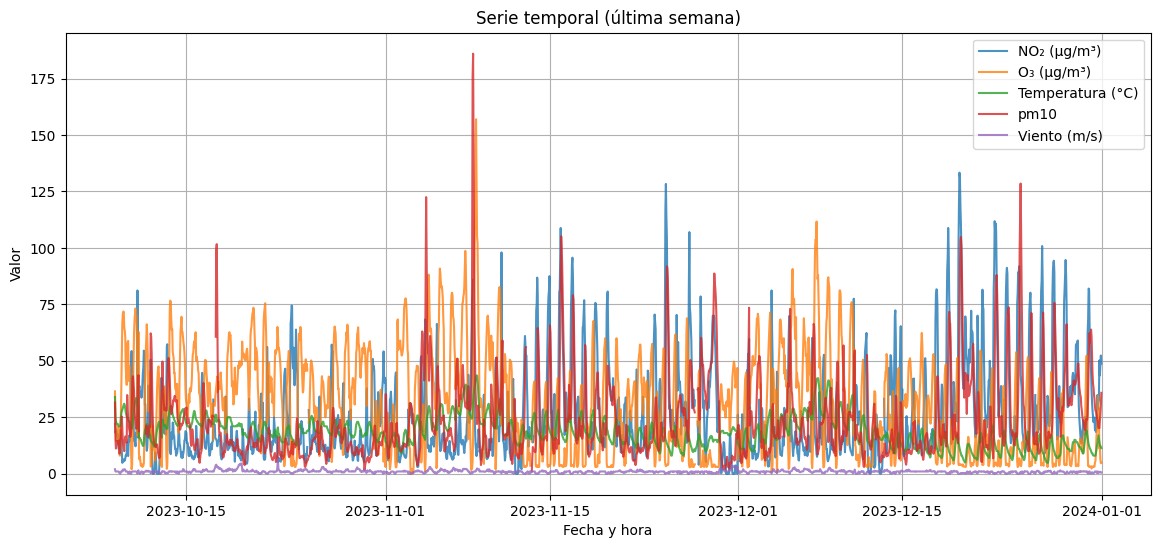

In [59]:
ultima_fecha = df.index.max()
inicio_meses = ultima_fecha - pd.Timedelta(weeks=12)
df_3meses = df.loc[inicio_meses:ultima_fecha]

print(f"Mostrando datos desde {inicio_meses.date()} hasta {ultima_fecha.date()}")

# --- 🔹 Graficar las variables principales ---
plt.figure(figsize=(14, 6))
plt.plot(df_3meses.index, df_3meses['no2'], label='NO₂ (µg/m³)', alpha=0.8)
plt.plot(df_3meses.index, df_3meses['o3'], label='O₃ (µg/m³)', alpha=0.8)
plt.plot(df_3meses.index, df_3meses['tmp'], label='Temperatura (°C)', alpha=0.8)
plt.plot(df_3meses.index, df_3meses['pm10'], label='pm10', alpha=0.8)
plt.plot(df_3meses.index, df_3meses['vv'], label='Viento (m/s)', alpha=0.8)
plt.title('Serie temporal (última semana)')
plt.xlabel('Fecha y hora')
plt.ylabel('Valor')
plt.legend()
plt.grid(True)
plt.show()

In [60]:
df_3meses.isna().sum()

co      15
no2     16
o3      15
pm10    36
tmp      0
vv       0
dtype: int64

In [61]:
df_3meses

,co,no2,o3,pm10,tmp,vv
datetime,,,,,,
2023-10-08 23:00:00,297.8333,22.1667,36.5000,31.5000,34.0000,2.0000
2023-10-09 00:00:00,309.1667,18.1667,23.0000,15.1667,24.8333,1.0000
2023-10-09 01:00:00,329.5000,19.0000,16.8333,11.1667,23.3333,1.0000
2023-10-09 02:00:00,334.6667,19.1667,14.5000,12.3333,22.3333,1.0000
2023-10-09 03:00:00,340.6667,16.5000,16.5000,14.5000,22.0000,1.0000
...,...,...,...,...,...,...
2023-12-31 19:00:00,716.8333,50.1667,11.1667,20.1667,14.5000,0.6667
2023-12-31 20:00:00,678.6667,43.5000,12.5000,23.5000,12.8333,0.8333
2023-12-31 21:00:00,758.8333,47.6667,6.5000,26.0000,12.0000,0.8333


## Imputación de nulos

In [62]:
from sklearn.impute import KNNImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
# 4.1: Imputación rápida para huecos pequeños con interpolación por columna
df_3mesesinterp = df_3meses.copy()
df_3mesesinterp = df_3mesesinterp.drop(columns=['co'])
for col in df_3mesesinterp.columns:
    # interpolación temporal; limit=6 -> no imputa tramos mayores a 6 horas (ajusta)
    df_3mesesinterp[col] = df_3mesesinterp[col].interpolate(method='time', limit=6)


print(df_3mesesinterp.isna().sum())

# 4.2: Para huecos más largos, usar IterativeImputer (e.g. BayesianRidge pred) o KNN
# crear features de tiempo para ayudar a imputar

df_imp = df_3mesesinterp.copy()
df_imp['hour'] = df_imp.index.hour
df_imp['dayofweek'] = df_imp.index.dayofweek
df_imp['month'] = df_imp.index.month

# Imputador iterativo (puede ser más robusto que KNN)
imp = IterativeImputer(random_state=0, max_iter=10)
cols = ['no2','o3','pm10','tmp','vv','hour','dayofweek','month']
imputed = imp.fit_transform(df_imp[cols])
df_imputed3meses = pd.DataFrame(imputed, index=df_imp.index, columns=cols)

# Volver a asignar sólo las variables originales (no los features)

no2      0
o3       0
pm10    12
tmp      0
vv       0
dtype: int64


In [63]:
df_imputed3meses.isna().sum()

no2          0
o3           0
pm10         0
tmp          0
vv           0
hour         0
dayofweek    0
month        0
dtype: int64

La variable que queremos predecir es el ozono.

## Modelo base sin exogenas

## falta meter las endogenas, media movil, .....

In [64]:
dfO3 = df_imputed3meses['o3'].astype(float)

In [65]:
dfO3

datetime
2023-10-08 23:00:00    36.5000
2023-10-09 00:00:00    23.0000
2023-10-09 01:00:00    16.8333
2023-10-09 02:00:00    14.5000
2023-10-09 03:00:00    16.5000
                        ...   
2023-12-31 19:00:00    11.1667
2023-12-31 20:00:00    12.5000
2023-12-31 21:00:00     6.5000
2023-12-31 22:00:00     4.6667
2023-12-31 23:00:00     4.8333
Name: o3, Length: 2017, dtype: float64

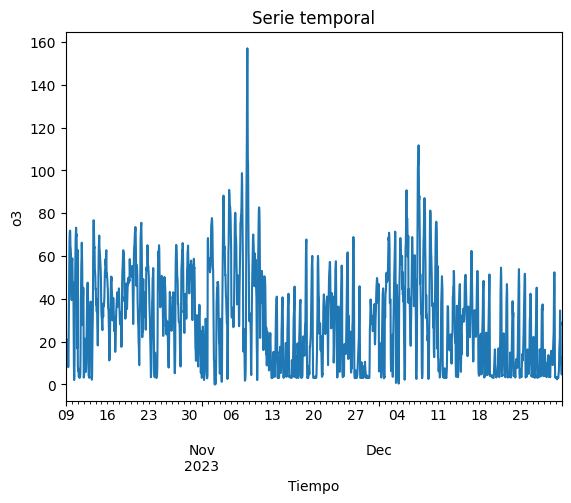

In [66]:
ax = dfO3.plot(title='Serie temporal')
ax.set_xlabel('Tiempo'); ax.set_ylabel('o3')
plt.show()

train:(1613,), valid:(202,), test:(202,)


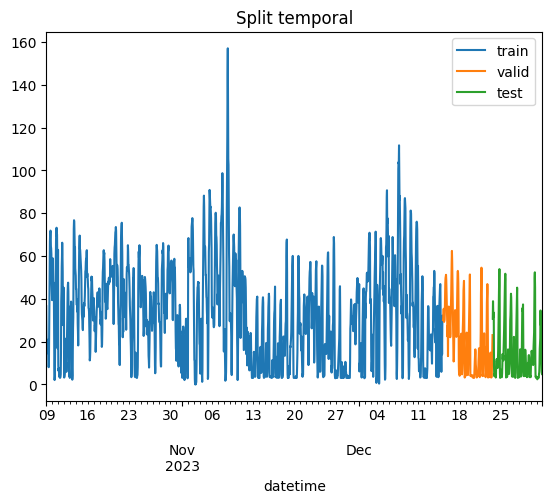

In [ ]:
# 5) Split y CV
n = len(dfO3)
train_end = int(0.8*n) # 74 dias entrenamiento
valid_end = int(0.9*n) # 4 díascde validacion y test

y_train = dfO3.iloc[:train_end]
y_valid = dfO3.iloc[train_end:valid_end]
y_test  = dfO3.iloc[valid_end:]

print(f"train:{y_train.shape}, valid:{y_valid.shape}, test:{y_test.shape}")

ax = y_train.plot(label='train')
y_valid.plot(ax=ax, label='valid')
y_test.plot(ax=ax, label='test', title='Split temporal')
ax.legend(); plt.show()

In [68]:
from skforecast.model_selection import TimeSeriesFold, grid_search_forecaster, backtesting_forecaster
# 1) Serie numérica ordenada
y = dfO3.astype(float).sort_index()

# 2) Inferir frecuencia; si existe, regularizar con asfreq
freq = pd.infer_freq(y.index)

if freq is not None:
    y = y.asfreq(freq)
if freq is not None:
    y_train.index = pd.DatetimeIndex(y_train.index, freq=freq)
    y_valid.index = pd.DatetimeIndex(y_valid.index, freq=freq)
else:
    print(' Serie sin frecuencia inferible. Puedes usar ignore_freq=True en fit/backtesting.')


print(f'Freq: {freq}')
print(f'Train: {y_train.index[0].date()} → {y_train.index[-1].date()} (n={len(y_train)})')
print(f'Valid: {y_valid.index[0].date()} → {y_valid.index[-1].date()} (n={len(y_valid)})')

cv = TimeSeriesFold(
    steps=len(y_valid),
    initial_train_size=len(y) - len(y_valid),
    fixed_train_size=True
)
cv

Freq: h
Train: 2023-10-08 → 2023-12-15 (n=1613)
Valid: 2023-12-15 → 2023-12-23 (n=202)


============== 
TimeSeriesFold 
============== 
Initial train size    = 1815,
Steps                 = 202,
Fold stride           = 202,
Overlapping folds     = False,
Window size           = None,
Differentiation       = None,
Refit                 = False,
Fixed train size      = True,
Gap                   = 0,
Skip folds            = None,
Allow incomplete fold = True,
Return all indexes    = False,
Verbose               = True

In [77]:
from skforecast.recursive import ForecasterRecursive
from skforecast.preprocessing import RollingFeatures

def tune_model(y, regressor, param_grid, lags_grid, cv, metric='mean_absolute_error', ignore_freq=None):
    """
    Ejecuta grid_search_forecaster() y devuelve SIEMPRE:
      - results_df: DataFrame con combinaciones evaluadas
      - f_best: ForecasterRecursive ajustado con la mejor configuración
    Compatible con variantes que devuelven dict o DataFrame.
    """
    window_features = RollingFeatures(
        stats = ['mean', 'std', 'min', 'max'],
        window_sizes = 24
    )
    f = ForecasterRecursive(regressor=regressor, lags=lags_grid[0] if len(lags_grid) else 12, window_features= window_features)
    kwargs = dict(
        forecaster=f, y=y, cv=cv, lags_grid=lags_grid, param_grid=param_grid,
        metric=metric, return_best=True, verbose=False
    )
    if ignore_freq:
        kwargs['ignore_freq'] = True

    out = grid_search_forecaster(**kwargs)

    if isinstance(out, dict) and 'results' in out and 'forecaster' in out:
        results_df, f_best = out['results'], out['forecaster']
    else:
        results_df, f_best = out, f  # algunas versiones devuelven DF y modifican f in-place

    return results_df, f_best


def backtest_best(f_best, y, cv, metric='mean_absolute_error', ignore_freq=None):
    """
    Devuelve:
      - metrics_out: métricas por split (tipo varía por versión)
      - preds_out: DF de predicciones o None
    Soporta API con/sin 'return_predict'.
    """
    kwargs = dict(forecaster=f_best, y=y, cv=cv, metric=metric, verbose=False)
    if ignore_freq:
        kwargs['ignore_freq'] = True

    try:
        metrics_out, preds_out = backtesting_forecaster(return_predict=True, **kwargs)
    except TypeError:
        out = backtesting_forecaster(**kwargs)
        if isinstance(out, tuple) and len(out) == 2:
            metrics_out, preds_out = out
        else:
            metrics_out, preds_out = out, None
    return metrics_out, preds_out


def extract_mae(metrics_out, metric_name='mean_absolute_error'):
    """Extrae un MAE medio de la salida de métricas, sea float/Series/DataFrame."""
    import numpy as _np
    import pandas as _pd
    if isinstance(metrics_out, (float, int, _np.floating, _np.integer)):
        return float(metrics_out)
    if isinstance(metrics_out, _pd.Series):
        return float(_pd.to_numeric(metrics_out, errors='coerce').mean())
    if isinstance(metrics_out, _pd.DataFrame):
        df = metrics_out.copy()
        if {'metric','value'}.issubset(df.columns):
            mask = (df['metric'] == metric_name)
            if mask.any():
                return float(_pd.to_numeric(df.loc[mask, 'value'], errors='coerce').mean())
            return float(_pd.to_numeric(df['value'], errors='coerce').mean())
        if metric_name in df.columns:
            return float(_pd.to_numeric(df[metric_name], errors='coerce').mean())
        if 'value' in df.columns:
            return float(_pd.to_numeric(df['value'], errors='coerce').mean())
        num = df.select_dtypes(include=_np.number)
        if not num.empty:
            return float(num.iloc[:, 0].mean())
    raise ValueError('Formato de métricas no reconocido para extraer MAE.')

In [78]:

# === Rejillas y ejecución de tuning ===

ridge = Ridge(random_state=0)
tree  = DecisionTreeRegressor(random_state=0)
rf    = RandomForestRegressor(random_state=0, n_estimators=200, n_jobs=-1)

lags_grid = [24, 48, 72, 168]
param_grid_ridge = {'alpha': [0.1, 1.0, 10.0]}
param_grid_tree  = {'max_depth': [3, 5, 8, None]}
param_grid_rf    = {'n_estimators': [200, 400], 'max_depth': [5, 10, None]}

print('Tuning Ridge...')
ridge_results, f_ridge_best = tune_model(y, ridge, param_grid_ridge, lags_grid, cv)

print('Tuning Decision Tree...')
tree_results,  f_tree_best  = tune_model(y, tree,  param_grid_tree,  lags_grid, cv)

print('Tuning Random Forest...')
rf_results,    f_rf_best    = tune_model(y, rf,    param_grid_rf,    lags_grid, cv)

# Vista previa de resultados de Ridge
ridge_results.head()

Tuning Ridge...


lags grid:   0%|          | 0/4 [00:00<?, ?it/s]

params grid:   0%|          | 0/3 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72] 
  Parameters: {'alpha': 0.1}
  Backtesting metric: 9.20109895759799
Tuning Decision Tree...


lags grid:   0%|          | 0/4 [00:00<?, ?it/s]

params grid:   0%|          | 0/4 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126
 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144
 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162
 163 164 165 166 167 168] 
  Parameters: {'max_depth': 5}
  Backtesting metric: 9.149960519638483
Tuning Random Forest...


lags grid:   0%|          | 0/4 [00:00<?, ?it/s]

params grid:   0%|          | 0/6 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126
 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144
 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162
 163 164 165 166 167 168] 
  Parameters: {'max_depth': 5, 'n_estimators': 200}
  Backtesting metric: 10.840669927862706


,lags,lags_label,params,mean_absolute_error,alpha
0,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",{'alpha': 0.1},9.201099,0.1
1,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",{'alpha': 1.0},9.201213,1.0
2,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",{'alpha': 10.0},9.202349,10.0
3,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",{'alpha': 0.1},9.558638,0.1
4,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",{'alpha': 1.0},9.559086,1.0


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Comparación de MAE (promedio CV):


,modelo,mae_cv
2,RandomForest,11.785355
1,DecisionTree,11.971208
0,Ridge,20.486688


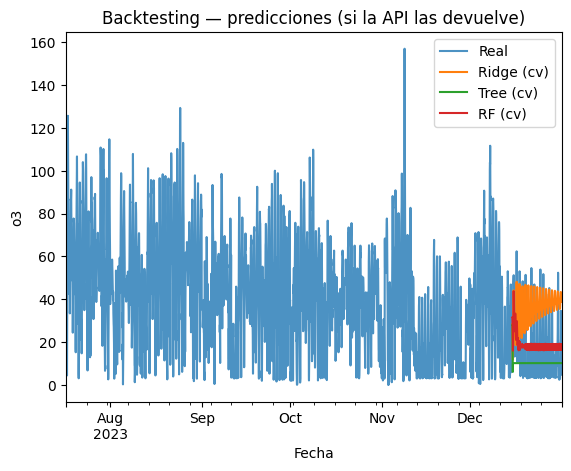

In [ ]:
# === Backtesting con los mejores modelos ===

m_ridge, p_ridge = backtest_best(f_ridge_best, y, cv)
m_tree,  p_tree  = backtest_best(f_tree_best,  y, cv)
m_rf,    p_rf    = backtest_best(f_rf_best,    y, cv)

# Comparación de MAE (promedio)
compare = pd.DataFrame({
    'modelo': ['Ridge', 'DecisionTree', 'RandomForest'],
    'mae_cv': [
        extract_mae(m_ridge, 'mean_absolute_error'),
        extract_mae(m_tree,  'mean_absolute_error'),
        extract_mae(m_rf,    'mean_absolute_error'),
    ]
}).sort_values('mae_cv')

print('Comparación de MAE (promedio CV):')
display(compare)

# Intentar graficar predicciones (si existen) del último tramo
def plot_cv_preds(preds, label):
    if preds is None or not isinstance(preds, pd.DataFrame):
        return False
    for col in ['pred', 'prediction', 'y_pred', 'forecast']:
        if col in preds.columns:
            preds[col].plot(label=label)
            return True
    return False

plt.figure()
y.plot(label='Real', alpha=0.8)
ok = False
ok |= plot_cv_preds(p_ridge, 'Ridge (cv)')
ok |= plot_cv_preds(p_tree,  'Tree (cv)')
ok |= plot_cv_preds(p_rf,    'RF (cv)')
plt.title('Backtesting — predicciones (si la API las devuelve)' if ok else
          'Backtesting — la API no devolvió predicciones (solo valores reales)')
plt.xlabel('Fecha'); plt.ylabel('o3')
plt.legend(); plt.show()

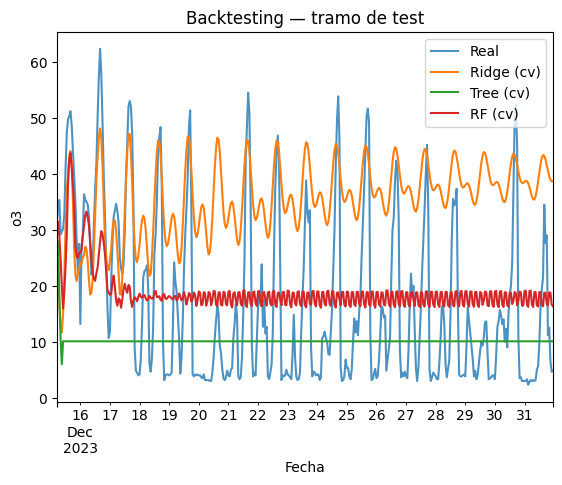

In [79]:
plt.figure()

# Determinar el rango temporal mínimo y máximo de las predicciones
fechas_min = min(df.index.min() for df in [p_ridge, p_tree, p_rf] if df is not None)
fechas_max = max(df.index.max() for df in [p_ridge, p_tree, p_rf] if df is not None)

# Recortar y al rango de test
y.loc[fechas_min:fechas_max].plot(label='Real', alpha=0.8)

ok = False
ok |= plot_cv_preds(p_ridge, 'Ridge (cv)')
ok |= plot_cv_preds(p_tree,  'Tree (cv)')
ok |= plot_cv_preds(p_rf,    'RF (cv)')

plt.title('Backtesting — tramo de test' if ok else 'No hay predicciones')
plt.xlabel('Fecha')
plt.ylabel('o3')
plt.legend()
plt.show()

## Modelo con variables exógenas (hacer grid search)

Para este modelo añadiremos las variables exógenas `NO2, vv, pm10 y tmp`.

In [80]:
df_imputed3meses

,no2,o3,pm10,tmp,vv,hour,dayofweek,month
datetime,,,,,,,,
2023-10-08 23:00:00,22.1667,36.5000,31.5000,34.0000,2.0000,23.0,6.0,10.0
2023-10-09 00:00:00,18.1667,23.0000,15.1667,24.8333,1.0000,0.0,0.0,10.0
2023-10-09 01:00:00,19.0000,16.8333,11.1667,23.3333,1.0000,1.0,0.0,10.0
2023-10-09 02:00:00,19.1667,14.5000,12.3333,22.3333,1.0000,2.0,0.0,10.0
2023-10-09 03:00:00,16.5000,16.5000,14.5000,22.0000,1.0000,3.0,0.0,10.0
...,...,...,...,...,...,...,...,...
2023-12-31 19:00:00,50.1667,11.1667,20.1667,14.5000,0.6667,19.0,6.0,12.0
2023-12-31 20:00:00,43.5000,12.5000,23.5000,12.8333,0.8333,20.0,6.0,12.0
2023-12-31 21:00:00,47.6667,6.5000,26.0000,12.0000,0.8333,21.0,6.0,12.0


In [81]:
y = df_imputed3meses['o3'].astype(float)
X = df_imputed3meses.drop(columns=['o3'])

In [82]:
# 2) Inferir frecuencia; si existe, regularizar con asfreq
freq = pd.infer_freq(y.index)

if freq is not None:
    y = y.asfreq(freq)
if freq is not None:
    y_train.index = pd.DatetimeIndex(y_train.index, freq=freq)
    y_valid.index = pd.DatetimeIndex(y_valid.index, freq=freq)
else:
    print('⚠️ Serie sin frecuencia inferible. Puedes usar ignore_freq=True en fit/backtesting.')


In [83]:
n = len(y)
train_end = int(0.8*n)
valid_end = int(0.9*n)

y_train = y.iloc[:train_end]
y_valid = y.iloc[train_end:valid_end]
y_test  = y.iloc[valid_end:]

X_train = X.loc[y_train.index]
X_valid = X.loc[y_valid.index]
X_test  = X.loc[y_test.index]

In [84]:
# Número de lags para el target
lags_exog = 168   # puedes probar 12, 24, 48, 168

window_features = RollingFeatures(
        stats = ['mean', 'std', 'min', 'max'],
        window_sizes = 24
    )
# Definición del forecaster
forecaster_exog = ForecasterRecursive(
    regressor=Ridge(random_state=0),
    lags=lags_exog,
    window_features=window_features
)

# Entrenamiento (usa ignore_freq=True si el índice no tiene freq)
forecaster_exog.fit(y=y_train, exog=X_train)

# Predicción sobre el tramo de validación
pred_exog = forecaster_exog.predict(steps=len(y_valid), exog=X_valid)

In [85]:
MAE_exog = mean_absolute_error(y_valid, pred_exog)
RMSE_exog = mean_squared_error(y_valid, pred_exog) ** 0.5

print(f"[BASE con exógenas] lags={lags_exog}  MAE={MAE_exog:.3f}  RMSE={RMSE_exog:.3f}")

[BASE con exógenas] lags=168  MAE=12.691  RMSE=15.178


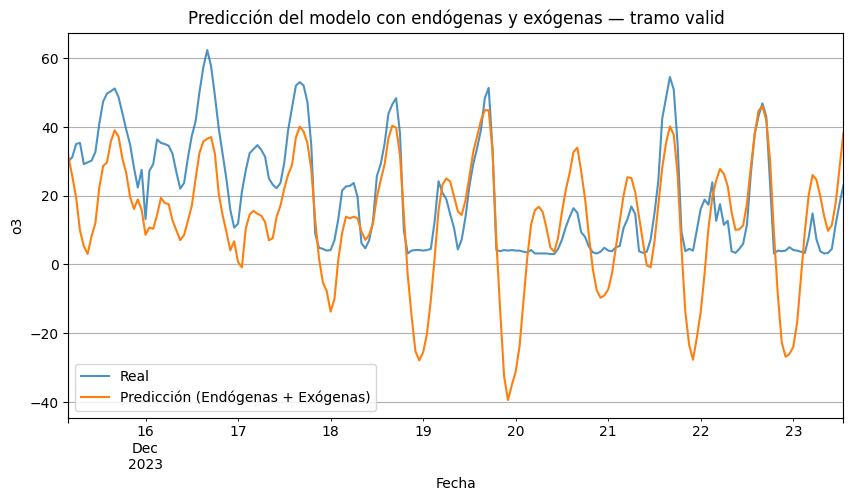

In [87]:
plt.figure(figsize=(10,5))
y_valid.plot(label='Real', color='tab:blue', alpha=0.8)
pred_exog.plot(label='Predicción (Endógenas + Exógenas)', color='tab:orange')
plt.title('Predicción del modelo con endógenas y exógenas — tramo valid')
plt.xlabel('Fecha'); plt.ylabel('o3')
plt.legend(); plt.grid(True)
plt.show()


Entrenando modelo: Ridge

Entrenando modelo: DecisionTree

Entrenando modelo: RandomForest


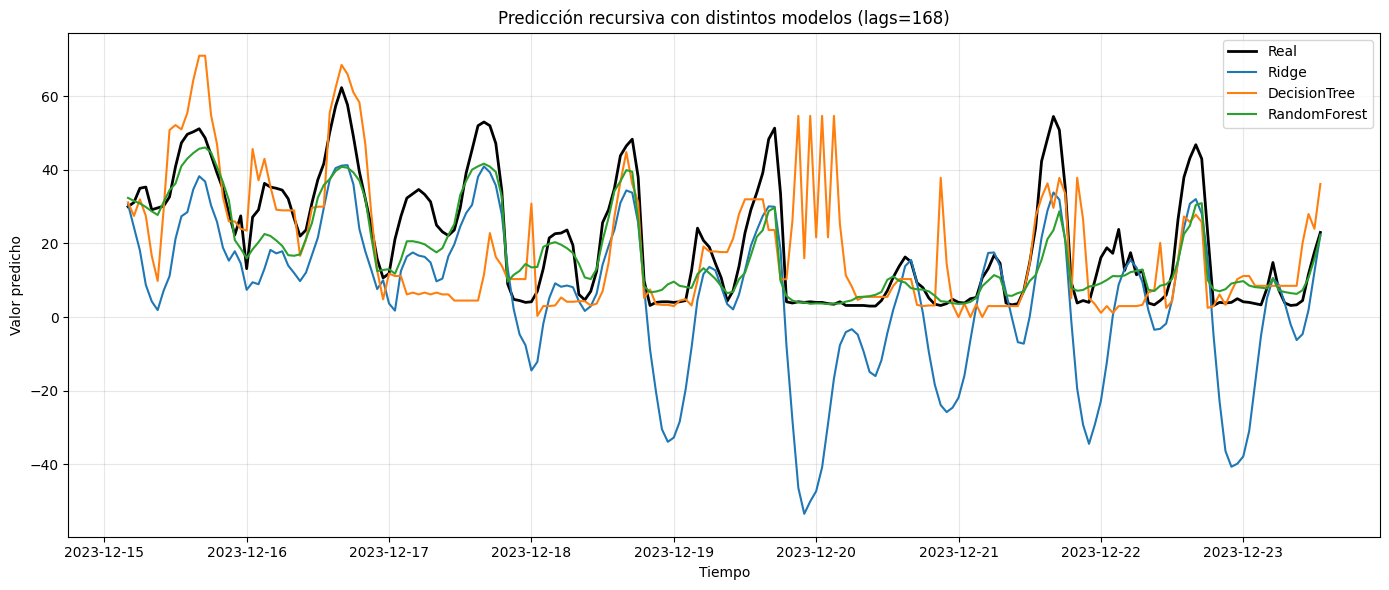

In [91]:
models = {
    'Ridge': Ridge(random_state=0),
    'DecisionTree': DecisionTreeRegressor(random_state=0),
    'RandomForest': RandomForestRegressor(n_estimators=100, random_state=0, n_jobs=-1)
}

# === ENTRENAMIENTO Y PREDICCIÓN ===
preds = {}

for name, model in models.items():
    print(f"\nEntrenando modelo: {name}")
    forecaster = ForecasterRecursive(
        regressor=model,
        lags=lags_exog
    )

    # Entrenar (usa ignore_freq=True si tu índice no tiene freq)
    forecaster.fit(y=y_train, exog=X_train)

    # Predecir el tramo de validación
    preds[name] = forecaster.predict(steps=len(y_valid), exog=X_valid)

# === GRAFICAR ===
plt.figure(figsize=(14, 6))
plt.plot(y_valid.index, y_valid, label='Real', color='black', linewidth=2)

for name, pred in preds.items():
    plt.plot(y_valid.index, pred, label=name)

plt.title(f'Predicción recursiva con distintos modelos (lags={lags_exog})')
plt.xlabel('Tiempo')
plt.ylabel('Valor predicho')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()